In [1]:
%load_ext autoreload 
%autoreload 2
from hig_data.vg import VgSceneGraphDataset

root = '/home/rfsm2/rds/hpc-work/datasets/vg/raw_vg/'
vg = VgSceneGraphDataset(vocab_json=root+'vocab.json',
                         h5_path=root+'val.h5',
                         image_dir='/home/rfsm2/rds/hpc-work/datasets/vg/all_vg_256',
                         image_size=(256,256),)

In [2]:
vg.vocab.keys()

dict_keys(['object_name_to_idx', 'object_idx_to_name', 'attribute_name_to_idx', 'attribute_idx_to_name', 'pred_name_to_idx', 'pred_idx_to_name'])

In [6]:
from training.encoders import CLIPEncoder
import numpy as np
import json
from tqdm import tqdm
clip = CLIPEncoder(batch_size=1)
vg_vocab_clip_latents = {}
target_keys = ['object_idx_to_name', 'attribute_idx_to_name', 'pred_idx_to_name']
for key in target_keys:
    latents = []
    for i, v in tqdm(enumerate(vg.vocab[key]), total=(len(vg.vocab[key]))):
        latents.append(clip.encode_raw_text(v, device='cuda')[0].cpu().tolist())
    vg_vocab_clip_latents[key] = latents

out_path = '/home/rfsm2/rds/hpc-work/datasets/vg/vocab_clip_latents.json'
with open(out_path, 'w') as json_file:
    json.dump(vg_vocab_clip_latents, json_file)


  0%|                                                                                                   | 0/6306 [00:00<?, ?it/s]

/home/rfsm2/.conda/envs/edm2/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 128.04it/s]


In [5]:
clip_latents = '/home/rfsm2/rds/hpc-work/datasets/vg/vocab_clip_latents.json'
with open(clip_latents, 'r') as json_file:
    clip_latents = json.load(json_file)
np.array(clip_latents['object_idx_to_name'][0]).shape

(768,)

In [86]:
vg.data['object_attributes'][300]

tensor([17,  1,  7, 32, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.int32)

In [89]:
vg.vocab['attribute_idx_to_name'][32]

'parked'

In [79]:
vg.data.keys()

dict_keys(['attributes_per_object', 'image_heights', 'image_ids', 'image_widths', 'object_attributes', 'object_boxes', 'object_ids', 'object_names', 'objects_per_image', 'relationship_ids', 'relationship_objects', 'relationship_predicates', 'relationship_subjects', 'relationships_per_image'])

In [77]:
vg.vocab.keys()

dict_keys(['object_name_to_idx', 'object_idx_to_name', 'attribute_name_to_idx', 'attribute_idx_to_name', 'pred_name_to_idx', 'pred_idx_to_name'])

In [90]:
 # get all object idxs
import numpy as np
import torch
import os
import PIL
index=300
raw_path = vg.image_paths[index].decode('utf-8')
raw_base_name = os.path.splitext(os.path.basename(raw_path))[0]
img_path = os.path.join(vg.image_dir, os.path.basename(raw_base_name)+'.png')
print(img_path)
WW, HH = np.array(vg.data['image_widths'][index]), np.array(vg.data['image_heights'][index])
obj_idxs = np.array(range(vg.data['objects_per_image'][index].item()))
n_objs = len(obj_idxs) 
print(f'n objs in img {n_objs}')
is_valid_obj = [True for _ in range(n_objs)]
obj_bbox = np.array(vg.data['object_boxes'][index][:n_objs])
obj_bbox, is_valid_obj = vg.filter_invalid_bbox(H=HH, W=WW, bbox=obj_bbox, is_valid_bbox=is_valid_obj)
obj_bbox = obj_bbox[is_valid_obj]
obj_bbox, is_valid_bb = vg.center_crop_bboxes_with_filter(WW, HH, bboxes=obj_bbox) # crop and resize w.r.t to original image size
obj_names =  vg.data['object_names'][index][is_valid_bb]

# create mapping
obj_idxs = obj_idxs[is_valid_bb]
n_objs = len(obj_idxs) 
objs = torch.LongTensor(n_objs).fill_(-1)
obj_idx_mapping = {}
for i, obj_idx in enumerate(obj_idxs):
    objs[i] = vg.data['object_names'][index, obj_idx].item()
    obj_idx_mapping[obj_idx] = i

triples = []
print('relationships_per_image', vg.data['relationships_per_image'][index].item())
for r_idx in range(vg.data['relationships_per_image'][index].item()):
    s = vg.data['relationship_subjects'][index, r_idx].item()
    p = vg.data['relationship_predicates'][index, r_idx].item()
    o = vg.data['relationship_objects'][index, r_idx].item()
    s = obj_idx_mapping.get(s, None)
    o = obj_idx_mapping.get(o, None)
    if s is not None and o is not None:
        triples.append([s, p, o])

triples = torch.LongTensor(triples)
objs, obj_bbox, triples, len(objs)

/home/rfsm2/rds/hpc-work/datasets/vg/all_vg_256/4378.png
n objs in img 19
relationships_per_image 1


(tensor([ 959,  298,    7,   19,   19,  109, 2192, 2192, 3376,  538, 5239,    1,
            1,    1,    1,    1]),
 array([[0.97546012, 0.        , 1.        , 1.        ],
        [0.06748466, 0.47852761, 0.91717791, 0.62883436],
        [0.08895706, 0.0398773 , 1.        , 0.89570552],
        [0.30674847, 0.76687117, 0.79754601, 0.94171779],
        [0.        , 0.76380368, 0.28834356, 0.90184049],
        [0.97852761, 0.        , 1.        , 0.99693252],
        [0.18711656, 0.58588957, 0.55214724, 0.6993865 ],
        [0.18711656, 0.58588957, 0.55828221, 0.6993865 ],
        [0.        , 0.7791411 , 0.28527607, 0.89877301],
        [0.30674847, 0.77607362, 0.79447853, 0.94785276],
        [0.09509202, 0.0398773 , 1.        , 0.89877301],
        [0.59815951, 0.29447853, 0.82515337, 0.51226994],
        [0.59509202, 0.2791411 , 0.8190184 , 0.51533742],
        [0.64110429, 0.7208589 , 0.79447853, 0.81288344],
        [0.16564417, 0.40490798, 0.2791411 , 0.56748466],
        [0.355

In [91]:
import PIL.Image

img = np.array(PIL.Image.open(img_path))
boxes = obj_bbox
labels = [vg.vocab['object_idx_to_name'][o] for o in objs]
print(labels)

['american flag', 'awning', 'building', 'car', 'car', 'flag', 'marquee', 'marquee', 'police car', 'station', 'theater', 'window', 'window', 'window', 'window', 'window']


In [92]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
def visualize_bounding_boxes(image: np.ndarray, bboxes: np.ndarray, labels: list, bbox_color='red', text_color='white'):
    """
    Visualizes bounding boxes on a numpy array image.
    
    Arguments:
        image: 2D NumPy array representing the image.
        bboxes: Bounding boxes as an Nx4 numpy array where each row is [xmin, ymin, xmax, ymax].
                Coordinates are expected to be in 0-1 normalized format.
        bbox_color: The color for the bounding boxes (default is red).
    """
    fig, ax = plt.subplots(1)
    ax.imshow(image,)
    
    # Image dimensions
    img_h, img_w, *_ = image.shape
    
    # Iterate over bounding boxes and draw them with labels
    for bbox, label in zip(bboxes, labels):
        # Denormalize bbox coordinates back to pixel values
        xmin, ymin, xmax, ymax = bbox * np.array([img_w, img_h, img_w, img_h])
        width = xmax - xmin
        height = ymax - ymin
        
        # Create a rectangle patch
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor=bbox_color, facecolor='none')
        ax.add_patch(rect)
        
        # Add label text
        ax.text(xmin, ymin - 5, label, color=text_color, fontsize=8, bbox=dict(facecolor=bbox_color, alpha=0.5, pad=1))

    plt.show()

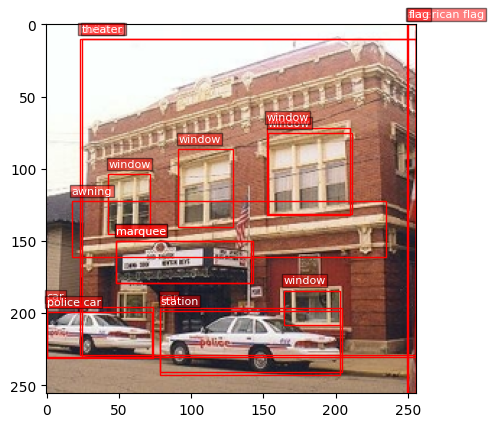

In [93]:
visualize_bounding_boxes(img, boxes, labels)

In [41]:
objs, boxes, triples = vg[10]
print(len(objs), len(boxes), len(triples))
objs, boxes, triples


VG_100K_2/189.jpg
10 10 2


(tensor([  61,   17,    8,   11, 1651,    2,   57,  218,   46,   -1]),
 tensor([[  0.,  60., 798., 353.],
         [  0., 166., 798., 248.],
         [  0.,  62., 798., 117.],
         [  0.,   0., 798.,  69.],
         [582., 247., 217.,  85.],
         [ 16.,  88., 173.,  82.],
         [524.,  98., 117.,  70.],
         [585., 251.,  65.,  62.],
         [774., 274.,  25.,  63.],
         [  0.,   0.,   1.,   1.]]),
 tensor([[ 0, 78,  1],
         [ 4,  3,  8]]))

In [3]:
for s,p,o in triples:
    s = vg.vocab['object_idx_to_name'][s]
    p = vg.vocab['pred_idx_to_name'][p]
    o = vg.vocab['object_idx_to_name'][o]
    print(f"{s} -> {p} -> {o}")

wall -> by -> __image__
man -> against -> tree
building -> under -> person
man -> against -> tree
ground -> with -> sign
shirt -> with -> window


In [2]:
import json
path = '/home/rfsm2/rds/hpc-work/datasets/vg/raw_vg/attributes.json'
with open(path, 'r') as f:
    data = json.load(f) 
print(data)


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [15]:
import h5py
path =  '/home/rfsm2/rds/hpc-work/datasets/vg/raw_vg/train.h5'
with h5py.File(path, 'r') as hdf:
    data_fnames = sorted(hdf.keys())
    # for k in data_fnames:
        # print(k, hdf[k][:1])
    # obj_boxes = hdf['object_boxes'][:]
    # obj_names = hdf['object_names'][:]

    

<Closed HDF5 file>

In [11]:
obj_names

array([[   2,   52,    7, ...,   -1,   -1,   -1],
       [  49,   52,    7, ...,   -1,   -1,   -1],
       [2598,   25, 1446, ...,   -1,   -1,   -1],
       ...,
       [  40, 1821,  138, ...,   -1,   -1,   -1],
       [ 148,  312,   21, ...,   -1,   -1,   -1],
       [ 100, 1373,  283, ...,   -1,   -1,   -1]], dtype=int32)

In [16]:
data_fnames

['attributes_per_object',
 'image_ids',
 'image_paths',
 'object_attributes',
 'object_boxes',
 'object_ids',
 'object_names',
 'objects_per_image',
 'relationship_ids',
 'relationship_objects',
 'relationship_predicates',
 'relationship_subjects',
 'relationships_per_image']

In [3]:
path = '/home/rfsm2/rds/hpc-work/datasets/vg/raw_vg/objects.json'
with open(path, 'r') as f:
    data = json.load(f) 
print(data[0])

{'image_id': 1, 'objects': [{'synsets': ['tree.n.01'], 'h': 557, 'object_id': 1058549, 'merged_object_ids': [], 'names': ['trees'], 'w': 799, 'y': 0, 'x': 0}, {'synsets': ['sidewalk.n.01'], 'h': 290, 'object_id': 1058534, 'merged_object_ids': [5046], 'names': ['sidewalk'], 'w': 722, 'y': 308, 'x': 78}, {'synsets': ['building.n.01'], 'h': 538, 'object_id': 1058508, 'merged_object_ids': [], 'names': ['building'], 'w': 222, 'y': 0, 'x': 1}, {'synsets': ['street.n.01'], 'h': 258, 'object_id': 1058539, 'merged_object_ids': [3798578], 'names': ['street'], 'w': 359, 'y': 283, 'x': 439}, {'synsets': ['wall.n.01'], 'h': 535, 'object_id': 1058543, 'merged_object_ids': [], 'names': ['wall'], 'w': 135, 'y': 1, 'x': 0}, {'synsets': ['tree.n.01'], 'h': 360, 'object_id': 1058545, 'merged_object_ids': [], 'names': ['tree'], 'w': 476, 'y': 0, 'x': 178}, {'synsets': ['shade.n.01'], 'h': 189, 'object_id': 5045, 'merged_object_ids': [], 'names': ['shade'], 'w': 274, 'y': 344, 'x': 116}, {'synsets': ['van.

In [6]:
path = '/home/rfsm2/rds/hpc-work/datasets/vg/raw_vg/scene_graphs.json'
with open(path, 'r') as f:
    data = json.load(f) 
print(data[0])

{'relationships': [{'synsets': ['along.r.01'], 'predicate': 'ON', 'relationship_id': 15927, 'object_id': 5046, 'subject_id': 5045}, {'synsets': ['wear.v.01'], 'predicate': 'wears', 'relationship_id': 15928, 'object_id': 5048, 'subject_id': 1058529}, {'synsets': ['have.v.01'], 'predicate': 'has', 'relationship_id': 15929, 'object_id': 5050, 'subject_id': 5049}, {'synsets': ['along.r.01'], 'predicate': 'ON', 'relationship_id': 15930, 'object_id': 1058508, 'subject_id': 1058507}, {'synsets': ['along.r.01'], 'predicate': 'ON', 'relationship_id': 15931, 'object_id': 1058534, 'subject_id': 5055}, {'synsets': ['have.v.01'], 'predicate': 'has', 'relationship_id': 15932, 'object_id': 1058511, 'subject_id': 1058529}, {'synsets': ['next.r.01'], 'predicate': 'next to', 'relationship_id': 15933, 'object_id': 1058539, 'subject_id': 1058534}, {'synsets': ['have.v.01'], 'predicate': 'has', 'relationship_id': 15934, 'object_id': 5060, 'subject_id': 1058515}, {'synsets': ['have.v.01'], 'predicate': 'has

In [7]:
print(data[0].keys())

dict_keys(['relationships', 'image_id', 'objects'])


In [16]:
data[0]['relationships']

[{'synsets': ['along.r.01'],
  'predicate': 'ON',
  'relationship_id': 15927,
  'object_id': 5046,
  'subject_id': 5045},
 {'synsets': ['wear.v.01'],
  'predicate': 'wears',
  'relationship_id': 15928,
  'object_id': 5048,
  'subject_id': 1058529},
 {'synsets': ['have.v.01'],
  'predicate': 'has',
  'relationship_id': 15929,
  'object_id': 5050,
  'subject_id': 5049},
 {'synsets': ['along.r.01'],
  'predicate': 'ON',
  'relationship_id': 15930,
  'object_id': 1058508,
  'subject_id': 1058507},
 {'synsets': ['along.r.01'],
  'predicate': 'ON',
  'relationship_id': 15931,
  'object_id': 1058534,
  'subject_id': 5055},
 {'synsets': ['have.v.01'],
  'predicate': 'has',
  'relationship_id': 15932,
  'object_id': 1058511,
  'subject_id': 1058529},
 {'synsets': ['next.r.01'],
  'predicate': 'next to',
  'relationship_id': 15933,
  'object_id': 1058539,
  'subject_id': 1058534},
 {'synsets': ['have.v.01'],
  'predicate': 'has',
  'relationship_id': 15934,
  'object_id': 5060,
  'subject_id': 1

In [12]:
data[0]['image_id']
data[0]['regions']

[{'relationships': [],
  'region_id': 1382,
  'width': 82,
  'synsets': [{'entity_idx_start': 4,
    'entity_idx_end': 9,
    'entity_name': 'clock',
    'synset_name': 'clock.n.01'},
   {'entity_idx_start': 22,
    'entity_idx_end': 28,
    'entity_name': 'colour',
    'synset_name': 'color.n.04'}],
  'height': 139,
  'image_id': 1,
  'objects': [{'name': 'clock',
    'h': 339,
    'object_id': 1058498,
    'synsets': ['clock.n.01'],
    'w': 79,
    'y': 91,
    'x': 421}],
  'phrase': 'the clock is green in colour',
  'y': 57,
  'x': 421},
 {'relationships': [{'synsets': ['along.r.01'],
    'predicate': 'ON',
    'relationship_id': 15927,
    'object_id': 5046,
    'subject_id': 5045}],
  'region_id': 1383,
  'width': 182,
  'synsets': [{'entity_idx_start': 0,
    'entity_idx_end': 5,
    'entity_name': 'shade',
    'synset_name': 'shade.n.01'},
   {'entity_idx_start': 19,
    'entity_idx_end': 25,
    'entity_name': 'street',
    'synset_name': 'street.n.01'}],
  'height': 109,
  '